<a href="https://colab.research.google.com/github/rhamdansyahrulm/Store-Sales/blob/main/Store_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><b>Preparing</b></h1>

<h2> Import Library </h2>

In [71]:
from google.colab import drive
import os
import datetime
import shutil
import zipfile
import re
import pickle
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import xgboost as xgb
from sklearn.metrics import mean_squared_error

<h2> Pull Data </h2>

In [16]:
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
source_file = "/content/drive/MyDrive/Project Data/kaggle.json"
destination_file = '/content/kaggle.json'
shutil.copy2(source_file, destination_file)
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [18]:
! chmod 600 /content/kaggle.json
! kaggle competitions download -c store-sales-time-series-forecasting

 75% 16.0M/21.4M [00:00<00:00, 167MB/s]
100% 21.4M/21.4M [00:00<00:00, 190MB/s]


In [19]:
# Extract file from zip file
zip_file_path = '/content/store-sales-time-series-forecasting.zip'
extract_dir = '/content/store-sales-time-series-forecasting'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("File successfully extracted!")

File successfully extracted!


<h1><b>Dataset Description</b></h1>

**predict sales for the thousands of product families sold at Favorita stores located in Ecuador**. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models.

In [20]:
# Initializing the folder path containing the dataset for time series-based store sales forecasting.
folder_dataset = '/content/store-sales-time-series-forecasting'

# Utilizing list comprehension to gather file names from the given path.
file_names = [f for f in os.listdir(folder_dataset) if os.path.isfile(os.path.join(folder_dataset, f))]

print(file_names)

['transactions.csv', 'stores.csv', 'sample_submission.csv', 'train.csv', 'test.csv', 'holidays_events.csv', 'oil.csv']


<h2><b>Train Datasets<b><h2>

<ul>
    <li>Training data, comprising time series of features:</li>
    <ul>
        <li><strong>store_nbr:</strong> Identifies the store at which the products are sold.</li>
        <li><strong>family:</strong> Identifies the type of product sold.</li>
        <li><strong>onpromotion:</strong> Gives the total number of items in a product family that were being promoted at a store at a given date.</li>
    </ul>
    <li><strong>Target sales:</strong> Gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (e.g., 1.5 kg of cheese).</li>
</ul>

In [21]:
# Loading the raw training dataset by reading the CSV file located in the specified folder path.
raw_train_dataset = pd.read_csv(os.path.join(folder_dataset,"train.csv"))
raw_train_dataset

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [22]:
# Obtaining information about the structure and attributes of the raw training dataset.
raw_train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [23]:
# Printing unique values for specific columns in the raw training dataset.
print("Unique Value\n")

# Printing unique values for the 'store_nbr' column along with the count of unique values.
print(f"store_nbr's Column => jumlah : {len(raw_train_dataset['store_nbr'].unique())}")
print("="*80)
print(raw_train_dataset["store_nbr"].unique())

# Printing unique values for the 'family' column along with the count of unique values.
print(f"\nfamily's Column => jumlah : {len(raw_train_dataset['family'].unique())}")
print("="*80)
print(raw_train_dataset["family"].unique())

Unique Value

store_nbr's Column => jumlah : 54
[ 1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30
 31 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45 46 47 48 49  5 50 51 52
 53 54  6  7  8  9]

family's Column => jumlah : 33
['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']


In [24]:
# Grouping the raw training dataset based on 'store_nbr' and 'family' columns,
# and calculating the count of occurrences for each combination of store and family.

raw_train_dataset.groupby(['store_nbr', 'family'])["family"].count()

store_nbr  family                    
1          AUTOMOTIVE                    1684
           BABY CARE                     1684
           BEAUTY                        1684
           BEVERAGES                     1684
           BOOKS                         1684
                                         ... 
54         POULTRY                       1684
           PREPARED FOODS                1684
           PRODUCE                       1684
           SCHOOL AND OFFICE SUPPLIES    1684
           SEAFOOD                       1684
Name: family, Length: 1782, dtype: int64

In [25]:
# Checking for missing values in the raw training dataset and printing the sum of missing values for each column.
print(raw_train_dataset.isnull().sum())

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64


<h2><b>Test Datasets<b><h2>

<ul>
  <li>The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.</li>
  <li>The dates in the test data are for the 15 days after the last date in the training data.</li>

In [26]:
# Loading the raw test dataset by reading the CSV file located in the specified folder path.
raw_test_dataset = pd.read_csv(os.path.join(folder_dataset,"test.csv"))
raw_test_dataset

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [27]:
# Obtaining information about the structure and attributes of the raw test dataset.
raw_test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [28]:
# Printing unique values for specific columns in the raw test dataset.
print("Unique Value\n")

# Printing unique values for the 'store_nbr' column along with the count of unique values.
print(f"store_nbr's Column => jumlah : {len(raw_test_dataset['store_nbr'].unique())}")
print("="*80)
print(raw_test_dataset["store_nbr"].unique())

# Printing unique values for the 'family' column along with the count of unique values.
print(f"\nfamily's Column => jumlah : {len(raw_test_dataset['family'].unique())}")
print("="*80)
print(raw_test_dataset["family"].unique())

Unique Value

store_nbr's Column => jumlah : 54
[ 1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30
 31 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45 46 47 48 49  5 50 51 52
 53 54  6  7  8  9]

family's Column => jumlah : 33
['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']


In [29]:
# Grouping the raw test dataset by the 'store_nbr' and 'family' columns,
# and calculating the count of occurrences for each combination of store and family.
raw_test_dataset.groupby(['store_nbr', 'family'])["family"].count()

store_nbr  family                    
1          AUTOMOTIVE                    16
           BABY CARE                     16
           BEAUTY                        16
           BEVERAGES                     16
           BOOKS                         16
                                         ..
54         POULTRY                       16
           PREPARED FOODS                16
           PRODUCE                       16
           SCHOOL AND OFFICE SUPPLIES    16
           SEAFOOD                       16
Name: family, Length: 1782, dtype: int64

In [30]:
# Checking for missing values in the raw test dataset and printing the sum of missing values for each column.
print(raw_test_dataset.isnull().sum())

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64


<h2><b>stores Dataset<b><h2>

<ul>
  <li>Store metadata, including city, state, type, and cluster.</li>
  <li>cluster is a grouping of similar stores.</li>

In [31]:
# Loading and exploring the 'stores' dataset.
# Loading the 'stores' dataset by reading the CSV file located in the specified folder path.
stores = pd.read_csv(os.path.join(folder_dataset,"stores.csv"))
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [32]:
# Obtaining information about the structure and attributes of the 'stores' dataset.
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [33]:
# Printing unique values for specific columns in the 'stores' dataset.
print("Unique Value\n")

# Printing unique values for the 'city' column along with the count of unique values.
print(f"City's Column => jumlah : {len(stores['city'].unique())}")
print("="*80)
print(stores["city"].unique())

# Printing unique values for the 'state' column along with the count of unique values.
print(f"\nState's Column => jumlah : {len(stores['state'].unique())}")
print("="*80)
print(stores["state"].unique())

# Printing unique values for the 'type' column along with the count of unique values.
print("Unique Value\n")
print(f"Type's Column => jumlah : {len(stores['type'].unique())}")
print("="*80)
print(stores["type"].unique())

# Printing unique values for the 'cluster' column along with the count of unique values.
print(f"\nCluster's Column => jumlah : {len(stores['cluster'].unique())}")
print("="*80)
print(stores["cluster"].unique())

Unique Value

City's Column => jumlah : 22
['Quito' 'Santo Domingo' 'Cayambe' 'Latacunga' 'Riobamba' 'Ibarra'
 'Guaranda' 'Puyo' 'Ambato' 'Guayaquil' 'Salinas' 'Daule' 'Babahoyo'
 'Quevedo' 'Playas' 'Libertad' 'Cuenca' 'Loja' 'Machala' 'Esmeraldas'
 'Manta' 'El Carmen']

State's Column => jumlah : 16
['Pichincha' 'Santo Domingo de los Tsachilas' 'Cotopaxi' 'Chimborazo'
 'Imbabura' 'Bolivar' 'Pastaza' 'Tungurahua' 'Guayas' 'Santa Elena'
 'Los Rios' 'Azuay' 'Loja' 'El Oro' 'Esmeraldas' 'Manabi']
Unique Value

Type's Column => jumlah : 5
['D' 'B' 'C' 'E' 'A']

Cluster's Column => jumlah : 17
[13  8  9  4  6 15  7  3 12 16  1 10  2  5 11 14 17]


<h2><b>holidays Events<b><h2>

<ul>
  <li>NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
</li>
  <li>Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).
</li>

In [34]:
# Loading and exploring the 'holidays_events' dataset.
# Loading the 'holidays_events' dataset by reading the CSV file located in the specified folder path.
holiday = pd.read_csv(os.path.join(folder_dataset,"holidays_events.csv"))
holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [35]:
# Obtaining information about the structure and attributes of the 'holidays_events' dataset.
holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [36]:
# Printing unique values for specific columns in the 'holidays_events' dataset.
print("Unique Value\n")

# Printing unique values for the 'type' column along with the count of unique values.
print(f"Type's Column => jumlah : {len(holiday['type'].unique())}")
print("="*80)
print(holiday['type'].unique())

# Printing unique values for the 'locale' column along with the count of unique values.
print(f"\nLocale's Column => jumlah : {len(holiday['locale'].unique())}")
print("="*80)
print(holiday['locale'].unique())

# Printing unique values for the 'locale_name' column along with the count of unique values.
print(f"\nLocale Name's Column => jumlah : {len(holiday['locale_name'].unique())}")
print("="*80)
print(holiday['locale_name'].unique())

# Printing unique values for the 'description' column along with the count of unique values.
print(f"\nnDescription's Column => jumlah : {len(holiday['description'].unique())}")
print("="*80)
print(holiday['description'].unique())

Unique Value

Type's Column => jumlah : 6
['Holiday' 'Transfer' 'Additional' 'Bridge' 'Work Day' 'Event']

Locale's Column => jumlah : 3
['Local' 'Regional' 'National']

Locale Name's Column => jumlah : 24
['Manta' 'Cotopaxi' 'Cuenca' 'Libertad' 'Riobamba' 'Puyo' 'Guaranda'
 'Imbabura' 'Latacunga' 'Machala' 'Santo Domingo' 'El Carmen' 'Cayambe'
 'Esmeraldas' 'Ecuador' 'Ambato' 'Ibarra' 'Quevedo'
 'Santo Domingo de los Tsachilas' 'Santa Elena' 'Quito' 'Loja' 'Salinas'
 'Guayaquil']

nDescription's Column => jumlah : 103
['Fundacion de Manta' 'Provincializacion de Cotopaxi'
 'Fundacion de Cuenca' 'Cantonizacion de Libertad'
 'Cantonizacion de Riobamba' 'Cantonizacion del Puyo'
 'Cantonizacion de Guaranda' 'Provincializacion de Imbabura'
 'Cantonizacion de Latacunga' 'Fundacion de Machala'
 'Fundacion de Santo Domingo' 'Cantonizacion de El Carmen'
 'Cantonizacion de Cayambe' 'Fundacion de Esmeraldas'
 'Primer Grito de Independencia' 'Fundacion de Riobamba'
 'Fundacion de Ambato' 'Fundacio

In [37]:
# Defining a function to process holiday descriptions, filtering and cleaning the text.
def process_description(text, words_to_find, words_to_remove):
    text_lower = text.lower()

    for word in words_to_remove:
        desc = re.sub(r'\b' + re.escape(word) + r'\b', '', text_lower)

    for word in words_to_find:
        match = re.search(word, desc)
        if match:
            return word
    return desc

# List of words to remove and words to find in holiday descriptions
words_to_remove = ['puente ', 'recupero ', 'traslado ']
words_to_find = ['fundacion', 'provincializacion', 'terremoto manabi', 'mundial de futbol brasil', 'fundacion', 'cantonizacion', 'primer dia del ano', 'independencia', 'navidad', 'dia de la madre']

# Filtering out transferred holidays and removing the 'transferred' column
holiday_no_transferred = holiday[holiday['transferred'] != True]
holiday_no_transferred = holiday_no_transferred.drop('transferred', axis=1)

# Creating a cleaned copy of the dataset and applying the process_description function to 'description' column
holiday_clean = holiday_no_transferred.copy()
holiday_clean['description'] = holiday['description'].apply(lambda x: process_description(x, words_to_find, words_to_remove))

# Printing unique values for the cleaned 'description' column
print(f"\nDescription's Column => jumlah : {len(holiday_clean['description'].unique())}")
print("="*80)
print(holiday_clean['description'].unique())

# Displaying the first few rows of the cleaned holiday dataset
holiday_clean.head()


Description's Column => jumlah : 18
['fundacion' 'provincializacion' 'cantonizacion' 'independencia'
 'dia de difuntos' 'navidad' 'primer dia del ano' 'carnaval'
 'viernes santo' 'dia del trabajo' 'dia de la madre'
 'batalla de pichincha' 'mundial de futbol brasil' 'black friday'
 'cyber monday' 'terremoto manabi' 'puente dia de difuntos'
 'recupero puente dia de difuntos']


,date,type,locale,locale_name,description
0,2012-03-02,Holiday,Local,Manta,fundacion
1,2012-04-01,Holiday,Regional,Cotopaxi,provincializacion
2,2012-04-12,Holiday,Local,Cuenca,fundacion
3,2012-04-14,Holiday,Local,Libertad,cantonizacion
4,2012-04-21,Holiday,Local,Riobamba,cantonizacion


In [38]:
# Converting the 'date' column in the 'oil' dataset to datetime format.
holiday_clean['date'] = pd.to_datetime(holiday_clean['date'])
holiday_clean["date"] = holiday_clean["date"] + timedelta(days=365*6+91)

# Renaming the 'type' column to 'case'
holiday_clean.rename(columns={'type': 'case'}, inplace=True)

holiday_clean.head()

,date,case,locale,locale_name,description
0,2018-05-31,Holiday,Local,Manta,fundacion
1,2018-06-30,Holiday,Regional,Cotopaxi,provincializacion
2,2018-07-11,Holiday,Local,Cuenca,fundacion
3,2018-07-13,Holiday,Local,Libertad,cantonizacion
4,2018-07-20,Holiday,Local,Riobamba,cantonizacion


In [39]:
# Dictionary to store label encoders
label_encoders = {}

label_encoder_case = LabelEncoder()

# For local holidays
Events_clean_local = holiday_clean[holiday_clean['locale'] == 'Local'].drop(columns=['locale'])
Events_clean_local.rename(columns={'locale_name': 'city'}, inplace=True)

# For regional holidays
Events_clean_regional = holiday_clean[holiday_clean['locale'] == 'Regional'].drop(columns=['locale'])
Events_clean_regional.rename(columns={'locale_name': 'state'}, inplace=True)

# For national holidays
Events_clean_National = holiday_clean[holiday_clean['locale'] == 'National'].drop(columns=['locale'])
Events_clean_National.drop(columns=['locale_name'], inplace=True)

<h2><b>Oil Datasets<b><h2>

<ul>
  <li>Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

In [40]:
# Loading and processing the 'oil' dataset.
# Loading the 'oil' dataset by reading the CSV file located in the specified folder path.
oil = pd.read_csv(os.path.join(folder_dataset,"oil.csv"))
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [41]:
# Obtaining information about the structure and attributes of the 'oil' dataset.
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [42]:
# Converting the 'date' column in the 'oil' dataset to datetime format.
oil['date'] = pd.to_datetime(oil['date'])

# Generating a date range based on the minimum and maximum dates in the 'oil' dataset.
date_range = pd.date_range(start=oil['date'].min(), end=oil['date'].max())

# Creating a DataFrame of missing dates in the 'oil' dataset by comparing with the generated date range.
missing_dates_oil = pd.DataFrame({'date': date_range})
missing_dates_oil = missing_dates_oil[~missing_dates_oil['date'].isin(oil['date'])]

# Creating a new dataset that includes all dates (including missing ones) and sorting by date.
oil_all_date = pd.concat([oil, missing_dates_oil]).sort_values('date').reset_index(drop=True)

oil_all_date

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,NaN
...,...,...
1699,2017-08-27,NaN
1700,2017-08-28,46.40
1701,2017-08-29,46.46
1702,2017-08-30,45.96


In [43]:
# Imputing missing values in the 'dcoilwtico' column using K-Nearest Neighbors regression.

# Extracting training data (non-null 'dcoilwtico' values) for input and target variables.
x_train = oil_all_date.loc[~oil_all_date['dcoilwtico'].isnull(), 'date'].values.reshape(-1, 1)
y_train = oil_all_date.loc[~oil_all_date['dcoilwtico'].isnull(), 'dcoilwtico']

# Extracting test data (null 'dcoilwtico' values) for input variables.
x_test = oil_all_date.loc[oil_all_date['dcoilwtico'].isnull(), 'date'].values.reshape(-1, 1)

# Setting the number of neighbors for K-Nearest Neighbors.
K = 3

# Creating a K-Nearest Neighbors regressor model and fitting it to the training data.
model = KNeighborsRegressor(n_neighbors=K)
model.fit(x_train, y_train)

# Making predictions for missing 'dcoilwtico' values using the trained model.
predictions = model.predict(x_test)

# Creating a copy of the dataset for imputed values.
oil_imputed = oil_all_date.copy()

# Imputing missing 'dcoilwtico' values with the predicted values.
oil_imputed.loc[oil_imputed['dcoilwtico'].isnull(), 'dcoilwtico'] = predictions
oil_imputed["date"] = pd.to_datetime(oil_imputed["date"])
oil_imputed["date"] = oil_imputed["date"] + timedelta(days=365*6+91)

oil_imputed

,date,dcoilwtico
0,2019-04-01,93.076667
1,2019-04-02,93.140000
2,2019-04-03,92.970000
3,2019-04-04,93.120000
4,2019-04-05,93.096667
...,...,...
1699,2023-11-25,46.836667
1700,2023-11-26,46.400000
1701,2023-11-27,46.460000
1702,2023-11-28,45.960000


<h2><b>Merge Datasets<b><h2>

In [44]:
# Creating a combined dataset from raw training and test datasets.
# Concatenating raw training and test datasets to create a combined dataset.
raw_combined_dataset = pd.concat([raw_train_dataset, raw_test_dataset], ignore_index=True)
raw_combined_dataset["date"] = pd.to_datetime(raw_combined_dataset["date"])
raw_combined_dataset["date"] = raw_combined_dataset["date"] + timedelta(days=365*6+91)
raw_combined_dataset = raw_combined_dataset.groupby(['store_nbr', 'date'])[['sales', 'onpromotion']].sum().reset_index()
raw_combined_dataset.head()

,store_nbr,date,sales,onpromotion
0,1,2019-04-01,0.000000,0
1,1,2019-04-02,7417.148000,0
2,1,2019-04-03,5873.244001,0
3,1,2019-04-04,5919.879001,0
4,1,2019-04-05,6318.785010,0


In [46]:
# Merging combined dataset with store information using 'store_nbr' as the common key.
raw_combined_dataset_stores = raw_combined_dataset.merge(stores, on='store_nbr', how='left')
raw_combined_dataset_stores.head()

,store_nbr,date,sales,onpromotion,city,state,type,cluster
0,1,2019-04-01,0.000000,0,Quito,Pichincha,D,13
1,1,2019-04-02,7417.148000,0,Quito,Pichincha,D,13
2,1,2019-04-03,5873.244001,0,Quito,Pichincha,D,13
3,1,2019-04-04,5919.879001,0,Quito,Pichincha,D,13
4,1,2019-04-05,6318.785010,0,Quito,Pichincha,D,13


In [47]:
# Grouping the merged dataset by 'store_nbr' column.
grouped = raw_combined_dataset_stores.groupby(['store_nbr'])

# Creating a dictionary to store separated data for each store-family combination.
separated_data = {}

# Iterating through the grouped data.
for group_name, group_data in grouped:
    store_number = group_name  # Get the store number from the group name
    key = f"store_{store_number}"
    separated_data[key] = group_data.reset_index(drop=True)

<ipython-input-47-534e9c367196>:8: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group_name, group_data in grouped:


In [48]:
separated_data['store_11']

,store_nbr,date,sales,onpromotion,city,state,type,cluster
0,11,2019-04-01,0.000000,0,Cayambe,Pichincha,B,6
1,11,2019-04-02,18329.638000,0,Cayambe,Pichincha,B,6
2,11,2019-04-03,12356.205040,0,Cayambe,Pichincha,B,6
3,11,2019-04-04,12171.998022,0,Cayambe,Pichincha,B,6
4,11,2019-04-05,14763.049000,0,Cayambe,Pichincha,B,6
...,...,...,...,...,...,...,...,...
1695,11,2023-11-25,0.000000,252,Cayambe,Pichincha,B,6
1696,11,2023-11-26,0.000000,195,Cayambe,Pichincha,B,6
1697,11,2023-11-27,0.000000,319,Cayambe,Pichincha,B,6
1698,11,2023-11-28,0.000000,315,Cayambe,Pichincha,B,6


In [49]:
# Dictionary to store the ready datasets
ready_dataset = {}
case_columns = ["case_National", "case_Local", "case_Regional"]
description_columns = ["description_National", "description_Local", "description_Regional"]

# Looping through each store-family combination's data
for key, value in separated_data.items():
    # Converting 'date' column to datetime format
    value['date'] = pd.to_datetime(value['date'])

    # Merging with imputed oil prices, local holidays, regional holidays, and national holidays
    merged_df_1 = value.merge(oil_imputed, on='date', how='left')
    merged_df_2 = merged_df_1.merge(Events_clean_local, on=['date', 'city'], how='left', suffixes=('', '_Local'))
    merged_df_3 = merged_df_2.merge(Events_clean_regional, on=['date', 'state'], how='left', suffixes=('_Local', '_Regional'))
    merged_df_4 = merged_df_3.merge(Events_clean_National, on='date', how='left', suffixes=('_Regional', '_National'))

    # Dropping irrelevant columns
    merged_df_4 = merged_df_4.drop(columns=["city", "state", "store_nbr", "type", "cluster"])

    # Setting the 'date' column as the index
    merged_df_4 = merged_df_4.set_index('date')
    merged_df_4 = merged_df_4.rename(columns={'case' : 'case_National', 'description' : 'description_National'})

    # Setting sales values to None for the last 150 days (test dataset)
    merged_df_4.loc[merged_df_4.index[-90:], "sales"] = None
    merged_df_4.loc[merged_df_4.index[-90:], "sales"] = None

    # Replace null values with "workday" in 'case' and 'description' columns
    for case_column in case_columns:
        merged_df_4[case_column].fillna("Work Day", inplace=True)
    for descripton_column in description_columns:
        merged_df_4[descripton_column].fillna("Work Day", inplace=True)

    # Storing the processed dataset in the dictionary
    ready_dataset[key] = merged_df_4

In [50]:
# Dictionary to store label encoders
label_encoders = {}

# Create a DataFrame with unique values from the "case" column in the "holiday_clean" dataset
unique_case = pd.DataFrame(holiday_clean["case"].unique(), columns=["case"])

# Initialize a LabelEncoder for the "case" column and fit it to unique values
label_encoder = LabelEncoder()
unique_case["case"] = label_encoder.fit(unique_case["case"])

# Store the label encoder in the dictionary with the key "case"
label_encoders["case"] = label_encoder

# Create a DataFrame with unique values of "description" grouped by "locale" from the "holiday_clean" dataset
unique_description = pd.DataFrame(holiday_clean[["description", "locale"]].groupby("locale")["description"].unique(), columns=["description"])

# Iterate over unique descriptions for each locale
for key, row in unique_description.iterrows():
    # Initialize a LabelEncoder for each set of unique descriptions
    label_encoder = LabelEncoder()
    row["description"] = np.append(row["description"], "Work Day")
    row["description"] = label_encoder.fit(row["description"])
    label_encoders[f"description_{key}"] = label_encoder

In [51]:
label_encoders

{'case': LabelEncoder(),
 'description_Local': LabelEncoder(),
 'description_National': LabelEncoder(),
 'description_Regional': LabelEncoder()}

In [52]:
encode_columns = ['case_National', 'case_Local', 'case_Regional', 'description_Local', 'description_Regional', 'description_National']

# Loop through the specified columns in the 'encode_columns' list and encode their values using the corresponding label encoders.
# The loop iterates over the 'ready_dataset' dictionary, where each key represents a dataset, and the associated value is a DataFrame.
for key, value in ready_dataset.items():
    for encode_column in encode_columns:
        # Determine the appropriate label encoder to use based on the column prefix ('case' or 'description').
        encoder_key = encode_column if encode_column.split("_")[0] != "case" else "case"
        value[encode_column] = label_encoders[encoder_key].transform(value[encode_column])


In [53]:
pkl_encoders = "label_encoders.pkl"
with open(pkl_encoders, "wb") as file :
  pickle.dump(label_encoders, file)

In [54]:
# Dictionary to store MinMaxScaler instances for each column and key
scalers = {}

# Looping through each store-family combination's ready dataset
for key, value in ready_dataset.items():
    # Initialize MinMaxScaler for this combination
    scaler = MinMaxScaler()

    # Fit the scaler on the dataset's numeric columns
    numeric_columns = value.select_dtypes(include=[np.number]).columns
    scaler.fit(value[numeric_columns])

    # Store the scaler in the dictionary
    scalers[key] = scaler

In [55]:
# transform a given DataFrame into a "windowed" format
def create_windowed_dataframe(df, window_size, stride):
    num_samples = len(df)
    windowed_data = []

    for i in range(0, num_samples - window_size + 1, stride):
        windowed_data.append(df.iloc[i:i+window_size].values)

    columns = [f'sales_{i}' if i != window_size else "y" for i in range(1, window_size + 1)]
    windowed_df = pd.DataFrame(windowed_data, columns=columns)

    return windowed_df

In [56]:
# Dictionary to store transformed datasets
transformed_datasets = {}

# Looping through each store-family combination's ready dataset and scaler
for key, value in ready_dataset.items():
    # Get the corresponding scaler
    scaler = scalers[key]

    # Transforming the numeric columns using the scaler
    numeric_columns = value.select_dtypes(include=[np.number]).columns
    scaled_values = scaler.transform(value[numeric_columns])

    # Creating a DataFrame with scaled values and original index and columns
    scaled_df = pd.DataFrame(scaled_values, columns=numeric_columns, index=value.index)

    # Concatenating scaled numeric columns with non-numeric columns
    transformed_df = pd.concat([scaled_df, value.drop(columns=numeric_columns)], axis=1).dropna().reset_index(drop=True)
    windowed_df = create_windowed_dataframe(transformed_df["sales"], 7, 1).dropna()
    mergings_df = pd.concat([transformed_df, windowed_df], axis=1).dropna()

    # Storing the transformed dataset in the dictionary
    transformed_datasets[key] = mergings_df.drop("sales", axis=1)

# Now the 'transformed_datasets' dictionary contains transformed datasets for each store-family combination.

In [57]:
transformed_datasets["store_10"].round(3).head()

,onpromotion,dcoilwtico,case_Local,description_Local,case_Regional,description_Regional,case_National,description_National,sales_1,sales_2,sales_3,sales_4,sales_5,sales_6,y
0,0.0,0.792,1.0,0.0,0.0,0.0,0.6,0.733,0.000,0.254,0.213,0.158,0.253,0.268,0.195
1,0.0,0.793,1.0,0.0,0.0,0.0,1.0,0.000,0.254,0.213,0.158,0.253,0.268,0.195,0.174
2,0.0,0.791,1.0,0.0,0.0,0.0,1.0,0.000,0.213,0.158,0.253,0.268,0.195,0.174,0.146
3,0.0,0.793,1.0,0.0,0.0,0.0,1.0,0.000,0.158,0.253,0.268,0.195,0.174,0.146,0.145
4,0.0,0.792,1.0,0.0,0.0,0.0,1.0,0.667,0.253,0.268,0.195,0.174,0.146,0.145,0.143


In [58]:
pkl_scaler = "scaler.pkl"
with open(pkl_scaler, "wb") as file :
  pickle.dump(scalers, file)

<h2><b>Create Machine Learning Model<b><h2>

In [59]:
# Creating datasets for training, testing, and prediction.

# Dictionaries to store the datasets
x_trains = {}
y_trains = {}
x_tests = {}
y_tests = {}
x_predicts = {}

# Looping through each store-family combination's ready dataset
for key, value in transformed_datasets.items():
    # Extracting training data (excluding the 'sales' column)
    train = value[~value["y"].isnull()]

    # Extracting test data (last 150 days of training data)
    test = train.loc[train.index[-150:]]

    # Separating features and target variables
    x_trains[key], y_trains[key] = train.iloc[:, :-1], train.iloc[:, -1].to_frame()
    x_tests[key], y_tests[key] = test.iloc[:, :-1], test.iloc[:, -1].to_frame()

In [60]:
y_tests["store_10"]

,y
1458,0.298278
1459,0.290070
1460,0.267164
1461,0.405662
1462,0.433454
...,...
1603,0.289145
1604,0.292967
1605,0.317066
1606,0.272086


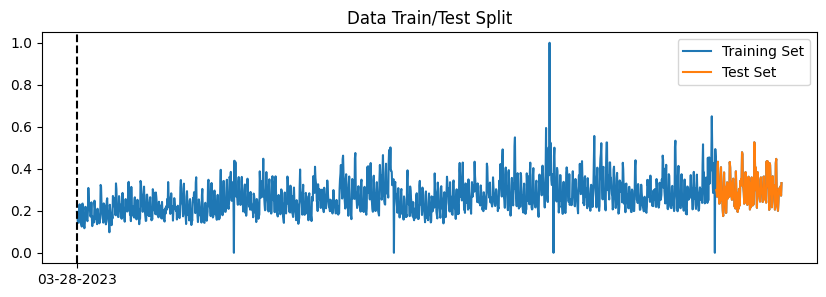

In [61]:
# Creating a plot to visualize the training and test data split.
fig, ax = plt.subplots(figsize=(10, 3)) # Creating a subplot with a specific figure size
y_trains["store_10"].plot(ax=ax, label='Training Set', title='Data Train/Test Split') # Plotting the training set's sales values
y_tests["store_10"].plot(ax=ax, label='Test Set') # Plotting the test set's sales values
ax.axvline('03-28-2023', color='black', ls='--') # Adding a vertical dashed line to indicate the split between training and test data
ax.legend (['Training Set', 'Test Set']) # Adding a legend to the plot
plt.show()

In [62]:
# Training XGBoost regressor models for selected store-family combinations.

# Dictionary to store trained regressor models
reg_models = {}

# Looping through each store-family combination's training data
for key, value in x_trains.items():
    # Extracting the store number from the key
    store_number = int(key.split("_")[1])

    # Creating an XGBoost regressor with specified parameters
    reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)

    # Fitting the regressor to the training data and evaluating on training and test sets
    reg.fit(x_trains[key], y_trains[key],
            eval_set=[(x_trains[key], y_trains[key]), (x_tests[key], y_tests[key])],
            verbose=False)

    # Storing the trained regressor in the dictionary
    reg_models[key] = reg

In [ ]:
# Dictionary to store RMSE values
rmse_values = {}

# Looping through each store-family combination's trained regressor
for key, reg_model in reg_models.items():
    # Predicting on the test set
    predictions = reg_model.predict(x_tests[key])

    # Calculating RMSE
    rmse = np.sqrt(mean_squared_error(y_tests[key], predictions))

    # Storing RMSE in the dictionary
    rmse_values[key] = rmse

# Displaying the RMSE values
for key, rmse in rmse_values.items():
    print(f"{key} : {rmse:.2f}")

In [64]:
reg_models.keys()

dict_keys(['store_1', 'store_2', 'store_3', 'store_4', 'store_5', 'store_6', 'store_7', 'store_8', 'store_9', 'store_10', 'store_11', 'store_12', 'store_13', 'store_14', 'store_15', 'store_16', 'store_17', 'store_18', 'store_19', 'store_20', 'store_21', 'store_22', 'store_23', 'store_24', 'store_25', 'store_26', 'store_27', 'store_28', 'store_29', 'store_30', 'store_31', 'store_32', 'store_33', 'store_34', 'store_35', 'store_36', 'store_37', 'store_38', 'store_39', 'store_40', 'store_41', 'store_42', 'store_43', 'store_44', 'store_45', 'store_46', 'store_47', 'store_48', 'store_49', 'store_50', 'store_51', 'store_52', 'store_53', 'store_54'])

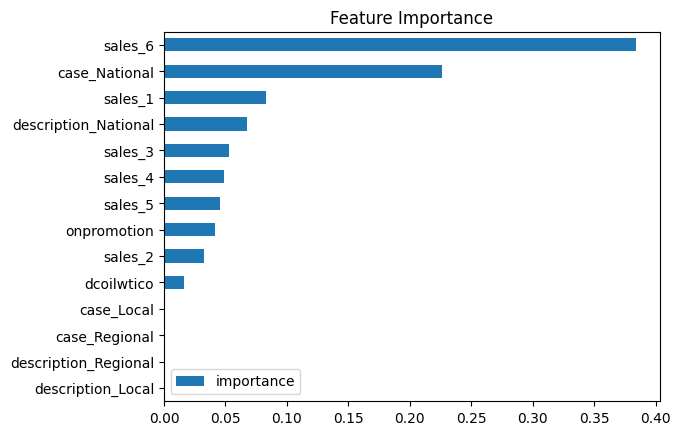

In [65]:
# Creating a bar plot to visualize feature importance for the trained XGBoost regressor.
# Creating a DataFrame to store feature importances
fi = pd.DataFrame(data=reg_models["store_5"].feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])

# Sorting the DataFrame by importance values and plotting as a horizontal bar plot
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')

plt.show()

In [66]:
# Making predictions on the test data using the trained regressor
test_model = reg_models["store_2"].predict(x_tests["store_2"])
predicted_test = x_tests["store_2"].copy()
predicted_test["predict"] = test_model
predicted_test["actual"] = y_tests["store_2"]

# Reordering columns to move "predict" column to the first position
actual_test = predicted_test[["actual"] + [col for col in predicted_test.columns if col not in ["actual", "predict"] and not any(col.startswith(f"sales_{i}") for i in range(1, 7))]]
predicted_test = predicted_test[["predict"] + [col for col in predicted_test.columns if col not in ["actual", "predict"] and not any(col.startswith(f"sales_{i}") for i in range(1, 7))]]

# Inverse transform the predicted and actual values to get them in original scale
actual_original_scale = scalers["store_2"].inverse_transform(actual_test)
predicted_original_scale = scalers["store_2"].inverse_transform(predicted_test)

# Convert the numpy arrays back to DataFrames
actual_original_df = pd.DataFrame(actual_original_scale, columns=actual_test.columns, index=actual_test.index)
predicted_original_df = pd.DataFrame(predicted_original_scale, columns=predicted_test.columns, index=predicted_test.index)

# Combine the "actual" column with the "predict" column
compare_y = pd.concat([actual_original_df['actual'], predicted_original_df['predict']], axis=1)

# Display the combined values
compare_y

,actual,predict
1458,18941.468000,18934.295824
1459,14372.649990,14427.187893
1460,18462.953000,18406.612873
1461,19167.570000,19224.763316
1462,22485.223000,22467.805927
...,...,...
1603,12940.504000,12986.168191
1604,12180.645000,12283.974974
1605,15447.921000,15339.992917
1606,12971.660001,12904.792559


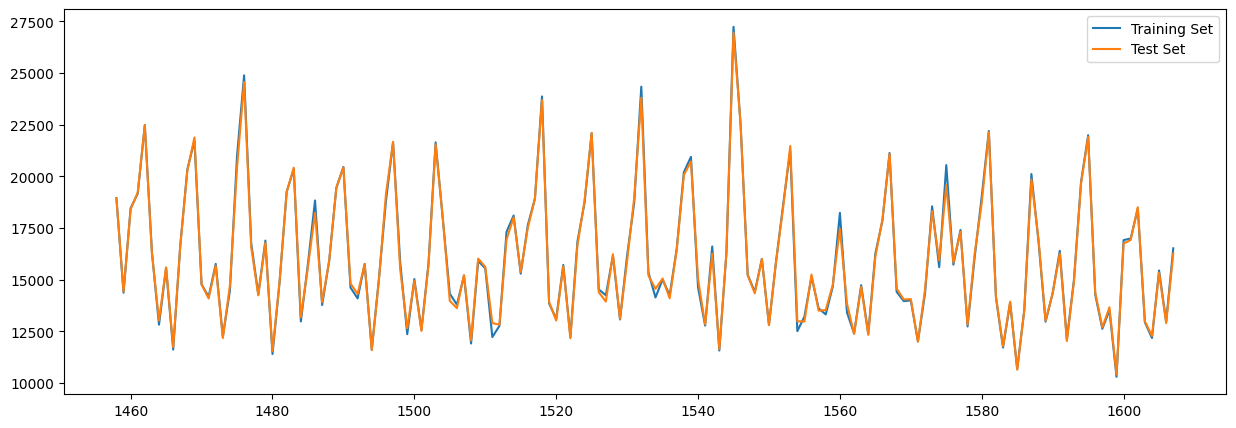

In [67]:
fig, ax = plt.subplots(figsize=(15, 5))
compare_y["actual"].plot(ax=ax, label='Test Set')
compare_y["predict"].plot(ax=ax, label='Test Set')
ax.legend (['Training Set', 'Test Set'])
plt.show()

In [68]:
# Create a folder to store the models
if not os.path.exists('reg_models'):
    os.makedirs('reg_models')

for key, model in reg_models.items():
    model_filename = os.path.join('reg_models', f'reg_{key}.pkl')
    joblib.dump(model, model_filename)

In [69]:
# Name of the zip file
zip_filename = 'reg_models.zip'

# Create a zip file to store the folder
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Add all files from the "reg_models" folder to the zip file
    for foldername, subfolders, filenames in os.walk('reg_models'):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            arcname = os.path.relpath(file_path, 'reg_models')
            zipf.write(file_path, arcname)

print(f'Zip file "{zip_filename}" created successfully.')

Zip file "reg_models.zip" created successfully.


## Testing predict

In [70]:
data_predict = pd.read_csv("test_predict.csv")

FileNotFoundError: ignored

In [ ]:
year = 2023
month = 9
start = datetime.datetime(year, month, 1)  # Convert to datetime object
end = datetime.datetime(year, month, 30)   # Convert to datetime object
raw_combined_dataset[(raw_combined_dataset["date"] >= start) & (raw_combined_dataset["date"] <= end)]

In [ ]:
# Tentukan ukuran gambar subplot
fig, axes = plt.subplots(9, 6, figsize=(15, 20), sharey=True)
fig.suptitle('Sales Comparison by Store', fontsize=16)

# Loop melalui setiap toko
for store in range(1, 55):
    # Hitung indeks subplot (baris dan kolom)
    row = (store - 1) // 6
    col = (store - 1) % 6

    # Buat subplot untuk toko saat ini
    ax = axes[row, col]

    # Plot data aktual untuk toko saat ini
    raw_combined_dataset[(raw_combined_dataset["date"] >= start) & (raw_combined_dataset["date"] <= end) & (raw_combined_dataset["store_nbr"] == store)]["sales"].reset_index(drop=True).plot(ax=ax, label='actual')

    # Plot data prediksi untuk toko saat ini
    data_predict[data_predict["store_nbr"] == store]["sales"].reset_index(drop=True).iloc[6:].reset_index(drop=True).plot(ax=ax, label='predict')

    # Tambahkan label dan legenda
    ax.set_title(f'Store {store}')
    ax.set_xlabel("Time")
    ax.set_ylabel("Sales")
    ax.legend(loc="upper left")

# Sisakan ruang di sekitar subplot
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Tampilkan plot
plt.show()